In [1]:
from fastai.vision.all import *
from fastai.learner import *
from fastai.data.all import *
from fastai.callback.tracker import SaveModelCallback
import pandas as pd
import matplotlib.pyplot as plt
from pathlib2 import Path
import numpy as np
import random
from torch.nn import MSELoss

In [2]:
%%time

df = pd.read_csv('data/examples_with_length.csv')
df.shape

CPU times: user 31 s, sys: 4.07 s, total: 35 s
Wall time: 50.2 s


(17937758, 11)

In [3]:
%%time
fn2features = pd.read_pickle('data/fn2feature.pkl')

CPU times: user 18.2 s, sys: 12.3 s, total: 30.5 s
Wall time: 1min 2s


In [4]:
df = df[((df.source_length < 70) & (df.target_length < 70) & (df.source_length > 25) & (df.target_length > 25))]
df.reset_index(drop=True, inplace=True)

In [5]:
df.target_length.max()

69

In [6]:
df.shape

(3336894, 11)

In [7]:
vocab = list(df.source_word.unique())

In [8]:
%%time

unique_fns = df.source_fn.unique()
np.random.shuffle(unique_fns)
lengths = []
for fn in df.target_fn:
    lengths.append(fn2features[fn].shape[0])

CPU times: user 3.95 s, sys: 0 ns, total: 3.95 s
Wall time: 3.95 s


In [9]:
max(lengths)

69

In [10]:
np.mean(lengths)

41.53269447576099

In [8]:
def empty_list(): return list()

In [ ]:
# %%time

# word2row_idxs = defaultdict(empty_list)

# for idx, row in df.iterrows():
#     word2row_idxs[row.source_word].append(idx)    

# pd.to_pickle(word2row_idxs, 'data/word2row_idxs_max_length.pkl')

In [9]:
word2row_idxs = pd.read_pickle('data/word2row_idxs_max_length.pkl')

In [10]:
def prepare_features(fn, pad_to=69, pad_left=False):
    ary = fn2features[fn][:pad_to]
    example = np.zeros((pad_to, 13))
    if pad_left:
        example[-ary.shape[0]:, :] = ary
    else: example[:ary.shape[0], :] = ary
    return example.astype(np.float32)

In [14]:
%%time

features = []
for fn in df.target_fn.unique():
    features.append(prepare_features(fn))

CPU times: user 11.8 s, sys: 2.4 s, total: 14.2 s
Wall time: 14.2 s


In [15]:
np.stack(features).mean(), np.stack(features).std()

(-2.9551291, 12.292017)

In [11]:
dataset_mean = -3
dataset_std = 12

def normalize_data(ary):
    return (ary - dataset_mean) / dataset_std

In [12]:
if np.nan in vocab: vocab.remove(np.nan)

In [13]:
class Dataset():
    def __init__(self, n):
        self.vocab = vocab * n
    def __len__(self):
        return len(self.vocab)
    def __getitem__(self, idx):
        row_idx = np.random.randint(len(word2row_idxs[self.vocab[idx]]))
        source_fn = df.source_fn[row_idx]
        target_fn = df.target_fn[row_idx]
        x = normalize_data(prepare_features(source_fn, pad_left=True))
        y = normalize_data(prepare_features(target_fn))
        return np.stack((x, y)), y

In [14]:
BS = 2048
LR = 1e-3
NUM_WORKERS = 8

train_dl = DataLoader(Dataset(270), BS, NUM_WORKERS, shuffle=True)
valid_dl = DataLoader(Dataset(30), BS, NUM_WORKERS)

dls = DataLoaders(train_dl, valid_dl)

In [15]:
# Got the following error while training:

# DataLoader worker (pid 2073) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.
# trying the solution I found here: https://github.com/pytorch/pytorch/issues/5040
# which is to execute
!sudo umount /dev/shm/ && sudo mount -t tmpfs -o rw,nosuid,nodev,noexec,relatime,size=50G shm /dev/shm

In [149]:
# bidirectional encoder, 1 layer, concatenate hidden state
class Model(Module):
    def __init__(self, hidden_size=25, num_layers_encoder=1):
        self.return_embeddings = False
        self.num_layers_encoder = num_layers_encoder
        self.hidden_size = hidden_size
        
        self.encoder= nn.LSTM(
            input_size=13,
            hidden_size=hidden_size,
            num_layers=self.num_layers_encoder,
            batch_first=True,
            dropout=0,
            bidirectional=True
        )
        self.decoder = nn.LSTM(
            input_size=2*hidden_size+13,
            hidden_size=2*hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=0,
            bidirectional=False
        )
        self.lin = nn.Linear(2*hidden_size, 13)
            
    def forward(self, source_and_target_features):
        source_features = source_and_target_features[:, 0]
        target_features = source_and_target_features[:, 1]
        _, (embeddings, _) = self.encoder(source_features)
        
        embeddings = embeddings.view(self.num_layers_encoder, 2, source_features.shape[0], self.hidden_size)
        embeddings = torch.cat([embeddings[:, 0, :, :], embeddings[:, 1, :, :]], -1)
        if self.return_embeddings: return embeddings
        
        target_features = torch.cat((torch.zeros(target_features.shape[0], 1, 13).cuda(), target_features), 1)
        inputs = torch.cat(
            (
                target_features[:, :-1, :],
                embeddings.permute(1, 0, 2).repeat(1, target_features.shape[1]-1, 1)
            ), 2)
        x, _ = self.decoder(inputs, (embeddings, torch.zeros_like(embeddings)))
        return self.lin(x)

In [150]:
# mse_loss = MSELoss()
# def targ_trunc_MSE(preds, targs):
#     return mse_loss(preds, targs[:, 1:, :])

learn = Learner(dls.cuda(), Model().cuda(), loss_func=MSELoss(), lr=1e-3, opt_func=Adam)

In [18]:
learn.fit(10, cbs=SaveModelCallback(fname='1e-3_Adam_tf', every_epoch=True), lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.032159,0.032242,07:47
1,0.026315,0.026207,07:58
2,0.023935,0.024272,07:55
3,0.028206,0.028116,08:08
4,0.023546,0.023384,07:48
5,0.021497,0.021651,07:45
6,0.020625,0.020479,07:35
7,0.027851,0.026035,07:20
8,0.021182,0.021215,07:26
9,0.019401,0.019287,07:24


In [50]:
learn.load('1e-3_Adam_tf_9')

In [51]:
learn.fit(6, cbs=SaveModelCallback(fname='1e-4_Adam_tf', every_epoch=True), lr=1e-4)

epoch,train_loss,valid_loss,time
0,0.018521,0.018576,07:44
1,0.018234,0.018354,07:39
2,0.018275,0.018186,07:32
3,0.018174,0.018096,07:27
4,0.017750,0.018036,07:28
5,0.017964,0.017947,07:26


In [76]:
learn.load('1e-4_Adam_tf_5')

In [77]:
learn.fit(20, cbs=SaveModelCallback(fname='1e-3_Adam_tf', every_epoch=True), lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.019970,0.019722,07:46
1,0.018607,0.018770,07:35
2,0.018282,0.018438,07:22
3,0.051871,0.039636,07:25
4,0.019165,0.018988,07:28
5,0.018124,0.017986,07:32
6,0.017593,0.017655,07:29
7,0.017248,0.017699,07:27
8,0.017199,0.017197,07:20
9,0.017112,0.016836,07:10


In [151]:
learn.load('1e-3_Adam_tf_19')

In [152]:
learn.fit(42, cbs=SaveModelCallback(fname='1e-3_Adam_tf', every_epoch=True), lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.018645,0.018543,07:40
1,0.017546,0.017415,07:37
2,0.016569,0.016618,07:27
3,0.017251,0.017052,07:25
4,0.016413,0.016466,07:20
5,0.017924,0.018027,07:19
6,0.016605,0.016391,07:21
7,0.015570,0.015593,07:17
8,0.015475,0.015545,07:14
9,0.017277,0.017325,07:27


In [ ]:
learn.fit(42, cbs=SaveModelCallback(fname='1e-4_Adam_tf', every_epoch=True), lr=1e-4)

## Calculate embedding for each unique word in the dataset

In [126]:
df_unique_utterances = df[df.set_name.isin(['train-clean-360', 'train-clean-100', 'dev-clean'])].drop_duplicates(['source_fn'])
df_unique_utterances.reset_index(drop=True, inplace=True)

In [127]:
class DatasetAllUtterances():
    def __len__(self):
        return df_unique_utterances.shape[0]
    def __getitem__(self, idx):
        source_fn = df_unique_utterances.iloc[idx].source_fn
        target_fn = df_unique_utterances.iloc[idx].target_fn
        x = normalize_data(prepare_features(source_fn, pad_left=True))
        y = normalize_data(prepare_features(target_fn))
        return np.stack((x, y)), y

In [128]:
all_dl = DataLoader(DatasetAllUtterances(), BS, NUM_WORKERS)

In [129]:
%%time

learn.model.return_embeddings = True
learn.model.train = False

all_embeddings = []

with torch.no_grad():    
    for batch in all_dl:
        embeddings = learn.model(batch[0].cuda())
        all_embeddings.append(embeddings.detach().cpu().squeeze(0))

CPU times: user 9.64 s, sys: 6.66 s, total: 16.3 s
Wall time: 2min 13s


In [130]:
all_embeddings = torch.cat(all_embeddings)

In [131]:
all_embeddings.shape

torch.Size([1837328, 50])

In [132]:
learn.model.return_embeddings = False

with torch.no_grad():
    for i, batch in enumerate(all_dl):
        outputs = learn.model(batch[0].cuda())
        break

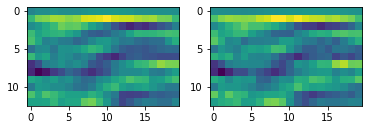

In [133]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(outputs[31].cpu().numpy().T[:, :20])
axs[1].imshow(batch[1][31].cpu().numpy().T[:, :20])

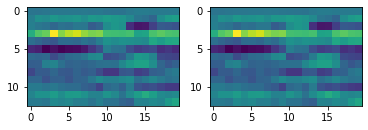

In [134]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(outputs[0].cpu().numpy().T[:, :20])
axs[1].imshow(batch[1][0].cpu().numpy().T[:, :20])

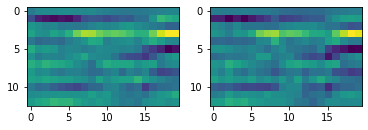

In [135]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(outputs[30].cpu().numpy().T[:, :20])
axs[1].imshow(batch[1][30].cpu().numpy().T[:, :20])

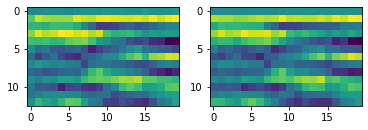

In [136]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(outputs[15].cpu().numpy().T[:, :20])
axs[1].imshow(batch[1][15].cpu().numpy().T[:, :20])

In [137]:
# %%time

# word2row_idxs_unique_utterances = defaultdict(empty_list)

# for idx, row in df_unique_utterances.iterrows():
#     word2row_idxs_unique_utterances[row.source_word].append(idx)
    
# pd.to_pickle(word2row_idxs_unique_utterances, 'word2row_idxs_unique_utterances_max_length.pkl')

In [138]:
word2row_idxs_unique_utterances = pd.read_pickle('word2row_idxs_unique_utterances_max_length.pkl')

In [139]:
word2embedding = {}

for k, v in word2row_idxs_unique_utterances.items():
    word2embedding[k] = all_embeddings[np.array(v)].mean(0)

In [140]:
word2embedding_without_nans= {}
nans_encountered = 0
for k, v in word2embedding.items():
    if k in vocab and k == k and (not np.isnan(v.numpy()).any()):
        word2embedding_without_nans[k] = v.numpy()
    else: nans_encountered += 1

print(f'Encountered rows with nan values: {nans_encountered}')

Encountered rows with nan values: 1


In [141]:
from utils import Embeddings

In [142]:
e = Embeddings(
    np.array(list(word2embedding_without_nans.values())),
    [w.lower() for w in list(word2embedding_without_nans.keys())]
)

In [143]:
for w in ['fast', 'lost', 'small', 'true', 'crazy', 'slow']:
    print(f'{w}: {e.nn_words_to(e[w])}')

fast: ['fast', 'guest', 'promised', 'trust', 'freckles']
lost: ['lost', 'thoughts', 'loss', 'paris', 'clothes']
small: ['small', 'tall', 'paul', 'call', 'sole']
true: ['true', 'do', 'too', 'to', 'two']
crazy: ['crazy', 'baby', 'gravely', 'gaily', 'flee']
slow: ['slow', 'so', 'spoil', 'skull', 'still']


## Evaluating embeddings using [word-embeddings-benchmarks](https://github.com/kudkudak/word-embeddings-benchmarks)

In [144]:
import logging
from six import iteritems
from web.datasets.similarity import fetch_MEN, fetch_WS353, fetch_SimLex999
from web.embeddings import fetch_GloVe
from web.evaluate import evaluate_similarity
from web.embedding import Embedding, Vocabulary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [145]:
tasks = {
    "MEN": fetch_MEN(),
    "WS353": fetch_WS353(),
    "SIMLEX999": fetch_SimLex999()
}

In [146]:
our_embeddings = Embedding(
    Vocabulary([w.lower() for w in list(word2embedding_without_nans.keys())]),
    np.array(list(word2embedding_without_nans.values()))
)

speech2vec = KeyedVectors.load_word2vec_format('../speech2vec-pretrained-vectors/speech2vec/50.vec', binary=False) 
speech2vec_embeddings = Embedding(Vocabulary(list(speech2vec.vocab.keys())), speech2vec.vectors)

In [147]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(our_embeddings, data.X, data.y)))

Missing 295 words. Will replace them with mean vector
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:336: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  A = np.vstack(w.get(word, mean_vector) for word in X[:, 0])
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  B = np.vstack(w.get(word, mean_vector) for word in X[:, 1])
Missing 58 words. Will replace them with mean vector
Missing 16 words. Will replace them with mean vector


Spearman correlation of scores on MEN -0.01654605907328508
Spearman correlation of scores on WS353 0.0012302660732448677
Spearman correlation of scores on SIMLEX999 -0.07999662347137036


In [148]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(speech2vec_embeddings, data.X, data.y)))

Missing 392 words. Will replace them with mean vector
Missing 61 words. Will replace them with mean vector
Missing 24 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.5896756323911225
Spearman correlation of scores on WS353 0.49890235673392536
Spearman correlation of scores on SIMLEX999 0.28202624769092116
